# Understanding attention in transformers

In [118]:
import torch
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt

%pip install -e .
from transformers.word_embedding import preprocess_text

/Users/juan.rodriguez/Desktop/Transformers/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


### Single head of attention

<img src="../inputs/single_head_attention.png" alt="Alt text" width="300">


1. We embed our sentence in a high-dimensional vector space encoding

In [191]:
sentence = ["Let's make artificial intelligence quantum"]

preprocessed_sentences = [preprocess_text(sent) for sent in sentence]
model = Word2Vec(preprocessed_sentences, vector_size=50, min_count=1)
word_vectors = torch.tensor(model.wv.vectors)
word_vectors[0]  # Example: Get the vector for the first word

tensor([-1.0725e-03,  4.7286e-04,  1.0207e-02,  1.8019e-02, -1.8606e-02,
        -1.4234e-02,  1.2918e-02,  1.7946e-02, -1.0031e-02, -7.5267e-03,
         1.4761e-02, -3.0669e-03, -9.0732e-03,  1.3108e-02, -9.7203e-03,
        -3.6320e-03,  5.7532e-03,  1.9837e-03, -1.6570e-02, -1.8898e-02,
         1.4624e-02,  1.0141e-02,  1.3515e-02,  1.5257e-03,  1.2702e-02,
        -6.8107e-03, -1.8928e-03,  1.1537e-02, -1.5043e-02, -7.8722e-03,
        -1.5023e-02, -1.8601e-03,  1.9076e-02, -1.4638e-02, -4.6675e-03,
        -3.8755e-03,  1.6155e-02, -1.1862e-02,  9.0325e-05, -9.5075e-03,
        -1.9207e-02,  1.0015e-02, -1.7519e-02, -8.7837e-03, -7.0200e-05,
        -5.9236e-04, -1.5322e-02,  1.9229e-02,  9.9641e-03,  1.8466e-02])

2. Generate Q, K, V matrices

In [193]:
seq_len = len(preprocessed_sentences[0])
emb_dim = word_vectors.shape[1]

Wq = torch.randn(emb_dim, emb_dim)
Wk = torch.randn(emb_dim, emb_dim)
Wv = torch.randn(emb_dim, emb_dim)

Q = torch.matmul(word_vectors, Wq)  # (seq_len, emb_dim)
K = torch.matmul(word_vectors, Wk)  # (seq_len, emb_dim)
V = torch.matmul(word_vectors, Wv)  # (seq_len, emb_dim)

word_vectors.shape

torch.Size([5, 50])

3. Dot product of query and key matrices and normalization

In [228]:
scores = torch.matmul(Q, K.transpose(-2, -1)) / emb_dim**0.5
scores.shape

torch.Size([5, 5])

4. Masking. This step ensures autoregressive behavior in self-attention. Because attention is computed in parallel, a causal mask is applied to prevent each token from attending to future tokens, ensuring the model cannot access information that comes later in the sequence.

In [229]:
L = scores.size(0)  # 5

mask = torch.triu(torch.ones(L, L, device=scores.device, dtype=torch.bool), diagonal=1)
scores_masked = scores.masked_fill(mask, float("-inf"))
scores_masked

tensor([[ 0.0051,    -inf,    -inf,    -inf,    -inf],
        [ 0.0058,  0.0109,    -inf,    -inf,    -inf],
        [-0.0039, -0.0019, -0.0036,    -inf,    -inf],
        [ 0.0009, -0.0044, -0.0040,  0.0124,    -inf],
        [ 0.0031,  0.0093, -0.0051,  0.0029,  0.0076]])

5. Apply softmax function to obtain probabilities

In [233]:
attn_weights = torch.softmax(scores_masked, dim=-1)
print([sum(attn_weights[i]) for i in range(seq_len)])  # each row sums to 1

[tensor(1.), tensor(1.), tensor(1.0000), tensor(1.), tensor(1.)]


In [234]:
attn_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4987, 0.5013, 0.0000, 0.0000, 0.0000],
        [0.3331, 0.3338, 0.3332, 0.0000, 0.0000],
        [0.2499, 0.2486, 0.2487, 0.2528, 0.0000],
        [0.1999, 0.2011, 0.1983, 0.1999, 0.2008]])

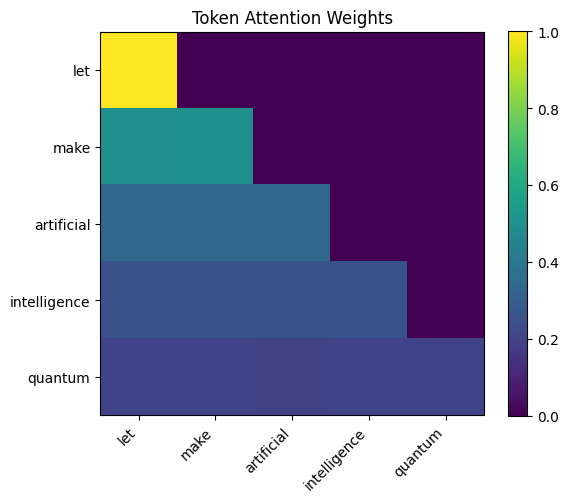

In [235]:
plt.figure(figsize=(max(6, seq_len * 0.7), max(5, seq_len * 0.6)))
plt.imshow(attn_weights.detach().numpy(), vmin=0, vmax=1)
plt.xticks(range(seq_len), preprocessed_sentences[0], rotation=45, ha="right")
plt.yticks(range(seq_len), preprocessed_sentences[0])
plt.colorbar()
plt.title("Token Attention Weights")
plt.tight_layout()
plt.show()

6. Multiply by the value vector

In [236]:
att_pattern = torch.matmul(attn_weights, V)
att_pattern.shape

torch.Size([5, 50])

7. Update embedding

In [237]:
updated_word_vectors = word_vectors + att_pattern
updated_word_vectors[0]

tensor([ 0.1845, -0.0734, -0.0428, -0.0013,  0.1358, -0.0136,  0.0663,  0.0305,
        -0.0315,  0.1088,  0.0268, -0.1679, -0.0186,  0.0014,  0.0514,  0.0167,
         0.0400, -0.0158, -0.1228,  0.1054, -0.0490,  0.1321, -0.0999,  0.2347,
         0.1341, -0.0950,  0.0044,  0.0616,  0.0827, -0.0809,  0.0139, -0.0235,
        -0.0386, -0.0182, -0.0211, -0.0600,  0.0616, -0.0978, -0.0273, -0.0086,
        -0.0399, -0.0516,  0.0525,  0.0099, -0.0841, -0.1627,  0.1100,  0.0539,
        -0.0207,  0.0541])

### Multi-head attention

In [186]:
num_heads = 2
seq_len = len(preprocessed_sentences[0])
emb_dim = word_vectors.shape[1]

word_vectors = torch.tensor(model.wv.vectors).unsqueeze(0).repeat(num_heads, 1, 1)  # (batch, seq_len, emb_dim)

Wq = torch.randn(num_heads, emb_dim, emb_dim)
Wk = torch.randn(num_heads, emb_dim, emb_dim)
Wv = torch.randn(num_heads, emb_dim, emb_dim)

Q = torch.matmul(word_vectors, Wq)  # (batch, seq_len, emb_dim)
K = torch.matmul(word_vectors, Wk)  # (batch, seq_len, emb_dim)
V = torch.matmul(word_vectors, Wv)  # (batch, seq_len, emb_dim)

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [2, 50] but got: [2, 5].

In [184]:
word_vectors.shape

torch.Size([2, 5, 50])

In [185]:
Wq.shape

torch.Size([2, 5, 5])